##In this file, I will be applying my matlab fretwheel code for ipython notebook!

In [27]:
import PIL#Useful module for loading and saving images
from PIL import Image
import numpy as np#Essential library of math operations (including numpy arrays, ~ matlab matrices)
import skimage#Powerful library of operations for segmentation and transformations
import matplotlib.pyplot as plt#Essential library for plotting
import plotly#Library for making figures pretty 
import tifffile as tif# Make sure to have both this file in the same directory but also the tifffile.c file for faster loading

#% is an example of an iPyNb magic function that allows us to show image in this same window (NOT a gui)

First, I'll need to load my donor, fret, and acceptor files that have a common prefix.'

Label for written file: cell7


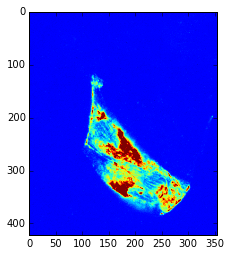

In [32]:
labelEFF= raw_input('Label for written file: ')#Prefix for set of data

#Load image stacks for each channel
donorStack= tif.imread(labelEFF+'Cropbleachdonor.tif')
fretStack= tif.imread(labelEFF+'Cropbleachfret.tif')
acceptorStack= tif.imread(labelEFF+'Cropbleachacceptor.tif')

#Will make the window interactive so that we can use ginput to select points
%matplotlib qt 
plt.imshow(acceptorStack[0], vmin= 0, vmax= 1000)
plt.show()#Equivalent to 'hold on' in Matlab, allows you plot on top of current figure

In [29]:
#Select background area
coords= ginput()

In [11]:
#Round coordinates
x= round(coords[0][0])
y= round(coords[0][1])
print x,y

272.0 185.0


In [140]:
# Below is an optional code to test the position of your window 
# plt.plot(x,y,'o',color= 'white')
# plt.plot(x-100,y-100,'ro', color= 'red')
# plt.plot(x+100,y+100,'ro', color= 'red')
# plt.plot(x-100,y+100,'ro', color= 'red')
# plt.plot(x+100,y-100,'ro', color= 'red')


In [12]:
#Now we'll take the average background from each channel in 21x21 window
#Make sure to list submatrix as [yStart:yEnd,xStart:xEnd]
donorBack= mean(donorStack[y-10:y+10,x-10:x+10])
fretBack= mean(fretStack[y-10:y+10,x-10:x+10])
acceptorBack= mean(acceptorStack[y-10:y+10,x-10:x+10])

print donorBack, fretBack, acceptorBack#Doublecheck values are reasonable


133.251379709 162.062351289 177.067457039


In [13]:
#Now we'll define bleed-through values (characteristic for your scope, collected previously)
btdonor= 0.6072;#40x air updated 1/21/15
btacceptor= 0.0437


###This is where we'll load all raw images for each timepoint, background subtract, bleed-through correct, calculate FRET efficiency, clean up image and write files to the directory.

In [14]:
import time
from tifffile import imsave

t0 = time.time()
for i in range(0,len(acceptorStack)):#Loop through stack for each channel
    donor= donorStack[i]
    fret= fretStack[i]
    acceptor= acceptorStack[i]
    
    donor= donor-donorBack#Background subtraction
    fret= fret-fretBack
    acceptor= acceptor-acceptorBack
    
    #Convert datatypes to doubles so we can get decimals from division
    donor= np.double(donor); fret= np.double(fret); acceptor= np.double(acceptor);
    fretcorrected= fret - donor*(btdonor) - acceptor*(btacceptor)#Bleedthrough correction for donor and acceptor channels.
    
    donor[donor<0]= nan#Threshold negative values (don't make sense)
    fret[fret<=0]= nan
    acceptor[acceptor<=0]= nan
    
    #Below we calculate FRET efficiency and threshold values by using the acceptor channel image as a reference
    efficiency= 100*(fretcorrected/(fretcorrected+donor));
    acceptorMask= acceptor<200#Threshold: acceptor pixels less than 100
    maskEff= efficiency#Initialize matrix
    maskEff[acceptorMask]= nan#At acceptorMask indices where intensity<100, turn to nan
    
    #This part of the code in Matlab assembled a structure with all parameters
    maskEff2= np.uint16(maskEff)#Convert data back into uint16 format to write a uint16 file
    imsave('python_write'+str(i)+'.tif',maskEff2)
    
    #saveFile= Image.fromarray(maskEff2, mode = 'I;16')#Convert to format Image.fromarray can recognize
    #saveFile.save('test_write.tif')#Write uint16 file :

    #saveFile.save('test_write.tif',saveeFile)#Write uint16 file :


t1= time.time()
total= t1-t0
print 'Time to calculate and write files: ', total

Time to calculate and write files:  4.25600004196


###Check the directory, although I couldn't get the files to write to a stack they're all there! The values are reasonable and match the Matlab output pretty well. In addition, this last for loop took us ~6.1 s to run whereas it took Matlab about 20s (after stripping .m file to make it comparable in tasks)! One final thing that I need to check is the thresholding because the data look cleaner in matlab (fewer speckles).

###Aside from that, it looks like fretwheel.py is a faster version of fretwheel.m :)

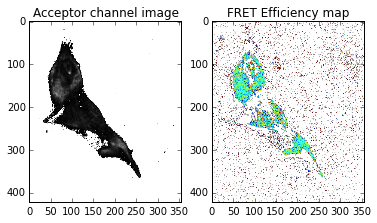

In [33]:
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(acceptor, cmap = cm.Greys_r)

plt.title('Acceptor channel image')


plt.subplot(1,2,2)
plt.imshow(maskEff, vmin= 0, vmax= 75)
plt.title('FRET Efficiency map')



In [15]:
#This command allows me to view the declared variables in my workspace
%whos

Variable        Type        Data/Info
-------------------------------------
Image           module      <module 'PIL.Image' from <...>-packages\PIL\Image.pyc'>
PIL             module      <module 'PIL' from 'c:\Us<...>ckages\PIL\__init__.pyc'>
acceptor        ndarray     422Lx356L: 150232 elems, type `float64`, 1201856 bytes (1 Mb)
acceptorBack    float64     177.067457039
acceptorMask    ndarray     422Lx356L: 150232 elems, type `bool`, 150232 bytes (146 kb)
acceptorStack   ndarray     192Lx422Lx356L: 28844544 elems, type `uint16`, 57689088 bytes (55 Mb)
btacceptor      float       0.0437
btdonor         float       0.6072
coords          list        n=1
donor           ndarray     422Lx356L: 150232 elems, type `float64`, 1201856 bytes (1 Mb)
donorBack       float64     133.251379709
donorStack      ndarray     192Lx422Lx356L: 28844544 elems, type `uint16`, 57689088 bytes (55 Mb)
efficiency      ndarray     422Lx356L: 150232 elems, type `float64`, 1201856 bytes (1 Mb)
fret            